### Import packages

In [11]:
import uproot as up
import awkward as ak
import numpy as np
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, DelphesSchema
from coffea import processor
import hist
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path
import mplhep as hep

In [2]:
f20="/gridgroup/cms/jxiao/lhe/samples/even_mphi20.root"
f40="/gridgroup/cms/jxiao/lhe/samples/even_mphi40.root"
f60="/gridgroup/cms/jxiao/lhe/samples/even_mphi60.root"
f80="/gridgroup/cms/jxiao/lhe/samples/even_mphi80.root"

In [3]:
eve20 = NanoEventsFactory.from_root(f20,treepath="Delphes",schemaclass=DelphesSchema).events()
eve40 = NanoEventsFactory.from_root(f40,treepath="Delphes",schemaclass=DelphesSchema).events()
eve60 = NanoEventsFactory.from_root(f60,treepath="Delphes",schemaclass=DelphesSchema).events()
eve80 = NanoEventsFactory.from_root(f80,treepath="Delphes",schemaclass=DelphesSchema).events()

In [9]:
eve20.Event.Weight

<Array [0.00584, 0.00584, ... 0.00584, 0.00584] type='50000 * float32[parameters...'>

### Functions

In [13]:
# events=eve_sig
# lhe_wgt = events.genWeight
# genlep_pt_min=15
# genjet_pt_min=15
# lep_jet_dr=0.4

# # with gen selections
# gleps = events.GenDressedLepton
# leps = gleps[(abs(gleps.pdgId)==11) | (abs(gleps.pdgId)==13) & (gleps.pt>genlep_pt_min)]
# eles = gleps[(abs(gleps.pdgId)==11) & (gleps.pt>genlep_pt_min)]
# mus = gleps[(abs(gleps.pdgId)==13) & (gleps.pt>genlep_pt_min)]

# n_lep = ak.num(leps,axis=1)
# leps=leps[n_lep>0]
# lep1=leps[:,0]
# lep1_wgt=lhe_wgt[n_lep>0]
# met=events.GenMET[n_lep>0]
# met_fid=events.MET[n_lep>0]

# n_ele = ak.num(eles,axis=1)
# eles=eles[n_ele>0]
# ele1=eles[:,0]
# ele1_wgt=lhe_wgt[n_ele>0]

# n_mu = ak.num(mus,axis=1)
# mus=mus[n_mu>0]
# mu1=mus[:,0]
# mu1_wgt=lhe_wgt[n_mu>0]

# gjets = events.GenJet[n_lep>0]
# jet_lep_matcher,jet_lep_dr=gjets.nearest(leps,axis=1,return_metric=True)
# jets = gjets[(gjets.pt>genjet_pt_min) & (jet_lep_dr>lep_jet_dr)]

# n_jet = ak.num(jets,axis=1)
# # n_jet = ak.fill_none(n_jet,0)
# # h_gencut_njet.fill(dataset=dataset, x=n_jet, weight=lhe_wgt)

# # h_gencut_njet.fill(dataset=dataset, x=n_jet, weight=lhe_wgt)
# jet1=jets[n_jet>0][:,0]
# jet1_wgt=(lhe_wgt[n_lep>0])[n_jet>0]

### Processor

In [92]:
class TriphotonProc(processor.ProcessorABC):
    def __init__(self):
        self.trigger_group = ".*SingleEle.*"
        self.analysis = "tagAndProbe"

        self.prefixes = {"tag": "tag", "probe": "probe"}

    def process(self, events: ak.Array):
        dataset = events.metadata['dataset']

        pho1_pt_min=10
        pho2_pt_min=10
        pho3_pt_min=10

        wgts=np.sign(events.Event.Weight)
        count_dict = defaultdict(int)
        count_dict["ntot"] += len(wgts)
        count_dict["npos"] += ak.sum(wgts>0)
        count_dict["nneg"] += ak.sum(wgts<0)
        count_dict["neff"] += (ak.sum(wgts>0)-ak.sum(wgts<0))
 
        nbins = 80
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        npho_axis = hist.axis.Regular(6, 0, 6, name="x", label="nPhoton")
        pho1_pt_axis = hist.axis.Regular(nbins, pho1_pt_min, 100, name="x", label=r"$p_{T}~(\gamma 1)$ [GeV]")
        pho2_pt_axis = hist.axis.Regular(int(nbins * 0.5), pho2_pt_min, 60, name="x", label=r"$p_{T}~(\gamma 2)$ [GeV]")
        pho3_pt_axis = hist.axis.Regular(int(nbins * 0.5), pho3_pt_min, 40, name="x", label=r"$p_{T}~(\gamma 3)$ [GeV]")

        pho12_pt_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="x", label=r"$p_{T}~(\gamma 1, \gamma 2)$ [GeV]")
        pho13_pt_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="x", label=r"$p_{T}~(\gamma 1, \gamma 3)$ [GeV]")
        pho23_pt_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="x", label=r"$p_{T}~(\gamma 2, \gamma 3)$ [GeV]")
        pho12_mass_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="x", label=r"$mass~(\gamma 1, \gamma 2)$ [GeV]")
        pho13_mass_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="x", label=r"$mass~(\gamma 1, \gamma 3)$ [GeV]")
        pho23_mass_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="x", label=r"$mass~(\gamma 2, \gamma 3)$ [GeV]")
        pho12_dr_axis = hist.axis.Regular(int(nbins * 0.5), 0, 6, name="x", label=r"$\Delta R~(\gamma 1, \gamma 2)$")
        pho13_dr_axis = hist.axis.Regular(int(nbins * 0.5), 0, 6, name="x", label=r"$\Delta R~(\gamma 1, \gamma 3)$")
        pho23_dr_axis = hist.axis.Regular(int(nbins * 0.5), 0, 6, name="x", label=r"$\Delta R~(\gamma 2, \gamma 3)$")

        y_pho12_pt_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="y", label=r"$p_{T}~(\gamma 1, \gamma 2)$ [GeV]")
        y_pho13_pt_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="y", label=r"$p_{T}~(\gamma 1, \gamma 3)$ [GeV]")
        y_pho23_pt_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="y", label=r"$p_{T}~(\gamma 2, \gamma 3)$ [GeV]")
        y_pho12_mass_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="y", label=r"$mass~(\gamma 1, \gamma 2)$ [GeV]")
        y_pho13_mass_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="y", label=r"$mass~(\gamma 1, \gamma 3)$ [GeV]")
        y_pho23_mass_axis = hist.axis.Regular(int(nbins * 0.5), 0, 90, name="y", label=r"$mass~(\gamma 2, \gamma 3)$ [GeV]")
        y_pho12_dr_axis = hist.axis.Regular(int(nbins * 0.5), 0, 6, name="y", label=r"$\Delta R~(\gamma 1, \gamma 2)$")
        y_pho13_dr_axis = hist.axis.Regular(int(nbins * 0.5), 0, 6, name="y", label=r"$\Delta R~(\gamma 1, \gamma 3)$")
        y_pho23_dr_axis = hist.axis.Regular(int(nbins * 0.5), 0, 6, name="y", label=r"$\Delta R~(\gamma 2, \gamma 3)$")

        pho123_pt_axis = hist.axis.Regular(int(nbins * 1), 0, 90, name="x", label=r"$p_{T}~(\gamma 1, \gamma 2, \gamma 3)$ [GeV]")
        pho123_mass_axis = hist.axis.Regular(int(nbins * 1), 0, 90, name="x", label=r"$mass~(\gamma 1, \gamma 2, \gamma 3)$ [GeV]")


        h_npho = hist.Hist(dataset_axis, npho_axis, storage="weight", label="Counts")
        h_pho1_pt = hist.Hist(dataset_axis, pho1_pt_axis, storage="weight", label="Counts")
        h_pho2_pt = hist.Hist(dataset_axis, pho2_pt_axis, storage="weight", label="Counts")
        h_pho3_pt = hist.Hist(dataset_axis, pho3_pt_axis, storage="weight", label="Counts")
        h_pho12_pt = hist.Hist(dataset_axis, pho12_pt_axis, storage="weight", label="Counts")
        h_pho13_pt = hist.Hist(dataset_axis, pho13_pt_axis, storage="weight", label="Counts")
        h_pho23_pt = hist.Hist(dataset_axis, pho23_pt_axis, storage="weight", label="Counts")
        h_pho12_mass = hist.Hist(dataset_axis, pho12_mass_axis, storage="weight", label="Counts")
        h_pho13_mass = hist.Hist(dataset_axis, pho13_mass_axis, storage="weight", label="Counts")
        h_pho23_mass = hist.Hist(dataset_axis, pho23_mass_axis, storage="weight", label="Counts")
        h_pho12_dr = hist.Hist(dataset_axis, pho12_dr_axis, storage="weight", label="Counts")
        h_pho13_dr = hist.Hist(dataset_axis, pho13_dr_axis, storage="weight", label="Counts")
        h_pho23_dr = hist.Hist(dataset_axis, pho23_dr_axis, storage="weight", label="Counts")
        h_pho123_pt = hist.Hist(dataset_axis, pho123_pt_axis, storage="weight", label="Counts")
        h_pho123_mass = hist.Hist(dataset_axis, pho123_mass_axis, storage="weight", label="Counts")

        h2d_pho12_pho13_mass = hist.Hist(dataset_axis, pho12_mass_axis, y_pho13_mass_axis, storage="weight", label="Counts")
        h2d_pho12_pho23_mass = hist.Hist(dataset_axis, pho12_mass_axis, y_pho23_mass_axis, storage="weight", label="Counts")
        h2d_pho13_pho23_mass = hist.Hist(dataset_axis, pho13_mass_axis, y_pho23_mass_axis, storage="weight", label="Counts")
        h2d_pho12_pho13_dr = hist.Hist(dataset_axis, pho12_dr_axis, y_pho13_dr_axis, storage="weight", label="Counts")
        h2d_pho12_pho23_dr = hist.Hist(dataset_axis, pho12_dr_axis, y_pho23_dr_axis, storage="weight", label="Counts")
        h2d_pho13_pho23_dr = hist.Hist(dataset_axis, pho13_dr_axis, y_pho23_dr_axis, storage="weight", label="Counts")

        h2d_pho12_mass_dr = hist.Hist(dataset_axis, pho12_mass_axis, y_pho12_dr_axis, storage="weight", label="Counts")
        h2d_pho13_mass_dr = hist.Hist(dataset_axis, pho13_mass_axis, y_pho13_dr_axis, storage="weight", label="Counts")
        h2d_pho23_mass_dr = hist.Hist(dataset_axis, pho23_mass_axis, y_pho23_dr_axis, storage="weight", label="Counts")

        phos=events.Photon
        n_pho = ak.num(phos.PT,axis=1)
        h_npho.fill(dataset=dataset, x=n_pho, weight=wgts)
        
        # selections
        sel_npho= (n_pho>2)
        phos=phos[sel_npho]
        wgts=wgts[sel_npho]
        sel_pho_pt_eta=(phos[:,0].pt>pho1_pt_min) & (np.abs(phos[:,0].eta)<2.4) &\
            (phos[:,1].pt>pho2_pt_min) & (np.abs(phos[:,1].eta)<2.4) &\
            (phos[:,2].pt>pho3_pt_min) & (np.abs(phos[:,2].eta)<2.4)
        phos=phos[sel_pho_pt_eta]
        wgts=wgts[sel_pho_pt_eta]
        pho1=phos[:,0]
        pho2=phos[:,1]
        pho3=phos[:,2]
        pho12=pho1+pho2
        pho13=pho1+pho3
        pho23=pho2+pho3
        pho123=pho1+pho2+pho3

        pho12_dr=pho1.delta_r(pho2)
        pho13_dr=pho1.delta_r(pho3)
        pho23_dr=pho2.delta_r(pho3)

        h_pho1_pt.fill(dataset=dataset, x=pho1.pt, weight=wgts)
        h_pho2_pt.fill(dataset=dataset, x=pho2.pt, weight=wgts)
        h_pho3_pt.fill(dataset=dataset, x=pho3.pt, weight=wgts)
        h_pho12_pt.fill(dataset=dataset, x=pho12.pt, weight=wgts)
        h_pho13_pt.fill(dataset=dataset, x=pho13.pt, weight=wgts)
        h_pho23_pt.fill(dataset=dataset, x=pho23.pt, weight=wgts)
        h_pho12_mass.fill(dataset=dataset, x=pho12.mass, weight=wgts)
        h_pho13_mass.fill(dataset=dataset, x=pho13.mass, weight=wgts)
        h_pho23_mass.fill(dataset=dataset, x=pho23.mass, weight=wgts)
        h_pho12_dr.fill(dataset=dataset, x=pho12_dr, weight=wgts)
        h_pho13_dr.fill(dataset=dataset, x=pho13_dr, weight=wgts)
        h_pho23_dr.fill(dataset=dataset, x=pho23_dr, weight=wgts)
        h_pho123_pt.fill(dataset=dataset, x=pho123.pt, weight=wgts)
        h_pho123_mass.fill(dataset=dataset, x=pho123.mass, weight=wgts)

        
        h2d_pho12_pho13_mass.fill(dataset=dataset, x=pho12.mass, y=pho13.mass, weight=wgts)
        h2d_pho12_pho23_mass.fill(dataset=dataset, x=pho12.mass, y=pho23.mass, weight=wgts)
        h2d_pho13_pho23_mass.fill(dataset=dataset, x=pho13.mass, y=pho23.mass, weight=wgts)
        h2d_pho12_pho13_dr.fill(dataset=dataset, x=pho12_dr, y=pho13_dr, weight=wgts)
        h2d_pho12_pho23_dr.fill(dataset=dataset, x=pho12_dr, y=pho23_dr, weight=wgts)
        h2d_pho13_pho23_dr.fill(dataset=dataset, x=pho13_dr, y=pho23_dr, weight=wgts)

        h2d_pho12_mass_dr.fill(dataset=dataset, x=pho12.mass, y=pho12_dr, weight=wgts)
        h2d_pho13_mass_dr.fill(dataset=dataset, x=pho13.mass, y=pho13_dr, weight=wgts)
        h2d_pho23_mass_dr.fill(dataset=dataset, x=pho23.mass, y=pho23_dr, weight=wgts)

        return {
            "h_npho": h_npho,
            "h_pho1_pt": h_pho1_pt,
            "h_pho2_pt": h_pho2_pt,
            "h_pho3_pt": h_pho3_pt,
            "h_pho12_pt": h_pho12_pt,
            "h_pho13_pt": h_pho13_pt,
            "h_pho23_pt": h_pho23_pt,
            "h_pho12_mass": h_pho12_mass,
            "h_pho13_mass": h_pho13_mass,
            "h_pho23_mass": h_pho23_mass,
            "h_pho12_mass": h_pho12_mass,
            "h_pho12_dr": h_pho12_dr,
            "h_pho13_dr": h_pho13_dr,
            "h_pho23_dr": h_pho23_dr,
            "h_pho123_pt": h_pho123_pt,
            "h_pho123_mass": h_pho123_mass,
            "h2d_pho12_pho13_mass": h2d_pho12_pho13_mass,
            "h2d_pho12_pho23_mass": h2d_pho12_pho23_mass,
            "h2d_pho13_pho23_mass": h2d_pho13_pho23_mass,
            "h2d_pho12_pho13_dr": h2d_pho12_pho13_dr,
            "h2d_pho12_pho23_dr": h2d_pho12_pho23_dr,
            "h2d_pho13_pho23_dr": h2d_pho13_pho23_dr,
            "h2d_pho12_mass_dr": h2d_pho12_mass_dr,
            "h2d_pho13_mass_dr": h2d_pho13_mass_dr,
            "h2d_pho23_mass_dr": h2d_pho23_mass_dr,

            "count": {dataset: count_dict},
        }

    def postprocess(self, accumulator):
        pass

### Get input files

In [93]:
fsig="FXFX-pythia8_eb-9686-3433f3604a70.root"
fbkg="/gridgroup/cms/jxiao/genval/wjet/out/nanogen_743529_554.root"
fileset = {
    'aaa_mphi20': ["/gridgroup/cms/jxiao/lhe/samples/even_mphi20.root"],
    'aaa_mphi40': ["/gridgroup/cms/jxiao/lhe/samples/even_mphi40.root"],
    'aaa_mphi60': ["/gridgroup/cms/jxiao/lhe/samples/even_mphi60.root"],
    'aaa_mphi80': ["/gridgroup/cms/jxiao/lhe/samples/even_mphi80.root"],
    'aaaj_mphi20': ["/gridgroup/cms/jxiao/lhe/samples/even_aaaj_mphi20.root"],
    'aaaj_mphi40': ["/gridgroup/cms/jxiao/lhe/samples/even_aaaj_mphi40.root"],
    'aaaj_mphi60': ["/gridgroup/cms/jxiao/lhe/samples/even_aaaj_mphi60.root"],
    'aaaj_mphi80': ["/gridgroup/cms/jxiao/lhe/samples/even_aaaj_mphi80.root"],
    'zaj_sm': ["/gridgroup/cms/jxiao/lhe/samples/zaj_sm.root"],
    'aaj_sm': ["/gridgroup/cms/jxiao/lhe/samples/aaj_sm.root"],
    'aaaj_sm': ["/gridgroup/cms/jxiao/lhe/samples/aaaj_sm.root"],
}


In [94]:
executor = processor.FuturesExecutor(workers=4)

run = processor.Runner(
    executor=executor,
    schema=DelphesSchema,
    # chunksize=_args.chunk,
    # maxchunks= 10,
    # format=_args.format,
    # skipbadfiles=_args.skipbadfiles,
)

output = run(
    fileset,
    treename="Delphes",
    processor_instance=TriphotonProc(),
)

Output()

In [95]:
coffea.util.save(output,"rlts.coffea")

### Load results

In [96]:
rlt=coffea.util.load("rlts.coffea")

In [97]:
(rlt["h2d_pho13_mass_dr"][{"dataset":"aaaj_mphi20"}].sum())["value"]

4030.0

In [98]:
plt_keys=[i for i in rlt.keys() if i.startswith("h")]
other_keys=[i for i in rlt.keys() if not i.startswith("h")]

In [99]:
plts_normed = {}
plts_normed["aaa_mphi20"]={}
plts_normed["aaa_mphi40"]={}
plts_normed["aaa_mphi60"]={}
plts_normed["aaa_mphi80"]={}
plts_normed["aaaj_mphi20"]={}
plts_normed["aaaj_mphi40"]={}
plts_normed["aaaj_mphi60"]={}
plts_normed["aaaj_mphi80"]={}
plts_normed["zaj_sm"]={}
plts_normed["aaj_sm"]={}
plts_normed["aaaj_sm"]={}
for i in plt_keys:
    # print(i,rlt[i])(rlt["h2d_pho13_mass_dr"][{"dataset":"aaaj_mphi20"}].sum())["value"]
    try:
        plts_normed["aaa_mphi20"][i]=rlt[i][{"dataset":"aaa_mphi20"}]/((rlt[i][{"dataset":"aaa_mphi20"}].sum())["value"])
        plts_normed["aaa_mphi40"][i]=rlt[i][{"dataset":"aaa_mphi40"}]/((rlt[i][{"dataset":"aaa_mphi40"}].sum())["value"])
        plts_normed["aaa_mphi60"][i]=rlt[i][{"dataset":"aaa_mphi40"}]/((rlt[i][{"dataset":"aaa_mphi60"}].sum())["value"])
        plts_normed["aaa_mphi80"][i]=rlt[i][{"dataset":"aaa_mphi40"}]/((rlt[i][{"dataset":"aaa_mphi80"}].sum())["value"])
        plts_normed["aaaj_mphi20"][i]=rlt[i][{"dataset":"aaaj_mphi20"}]/((rlt[i][{"dataset":"aaaj_mphi20"}].sum())["value"])
        plts_normed["aaaj_mphi40"][i]=rlt[i][{"dataset":"aaaj_mphi40"}]/((rlt[i][{"dataset":"aaaj_mphi40"}].sum())["value"])
        plts_normed["aaaj_mphi60"][i]=rlt[i][{"dataset":"aaaj_mphi60"}]/((rlt[i][{"dataset":"aaaj_mphi60"}].sum())["value"])
        plts_normed["aaaj_mphi80"][i]=rlt[i][{"dataset":"aaaj_mphi80"}]/((rlt[i][{"dataset":"aaaj_mphi80"}].sum())["value"])
        plts_normed["zaj_sm"][i]=rlt[i][{"dataset":"zaj_sm"}]/((rlt[i][{"dataset":"zaj_sm"}].sum())["value"])
        plts_normed["aaj_sm"][i]=rlt[i][{"dataset":"aaj_sm"}]/((rlt[i][{"dataset":"aaj_sm"}].sum())["value"])
        plts_normed["aaaj_sm"][i]=rlt[i][{"dataset":"aaaj_sm"}]/((rlt[i][{"dataset":"aaaj_sm"}].sum())["value"])
    except:
        pass

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fb759b87eb0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fb759bd9cc0>, text=[])

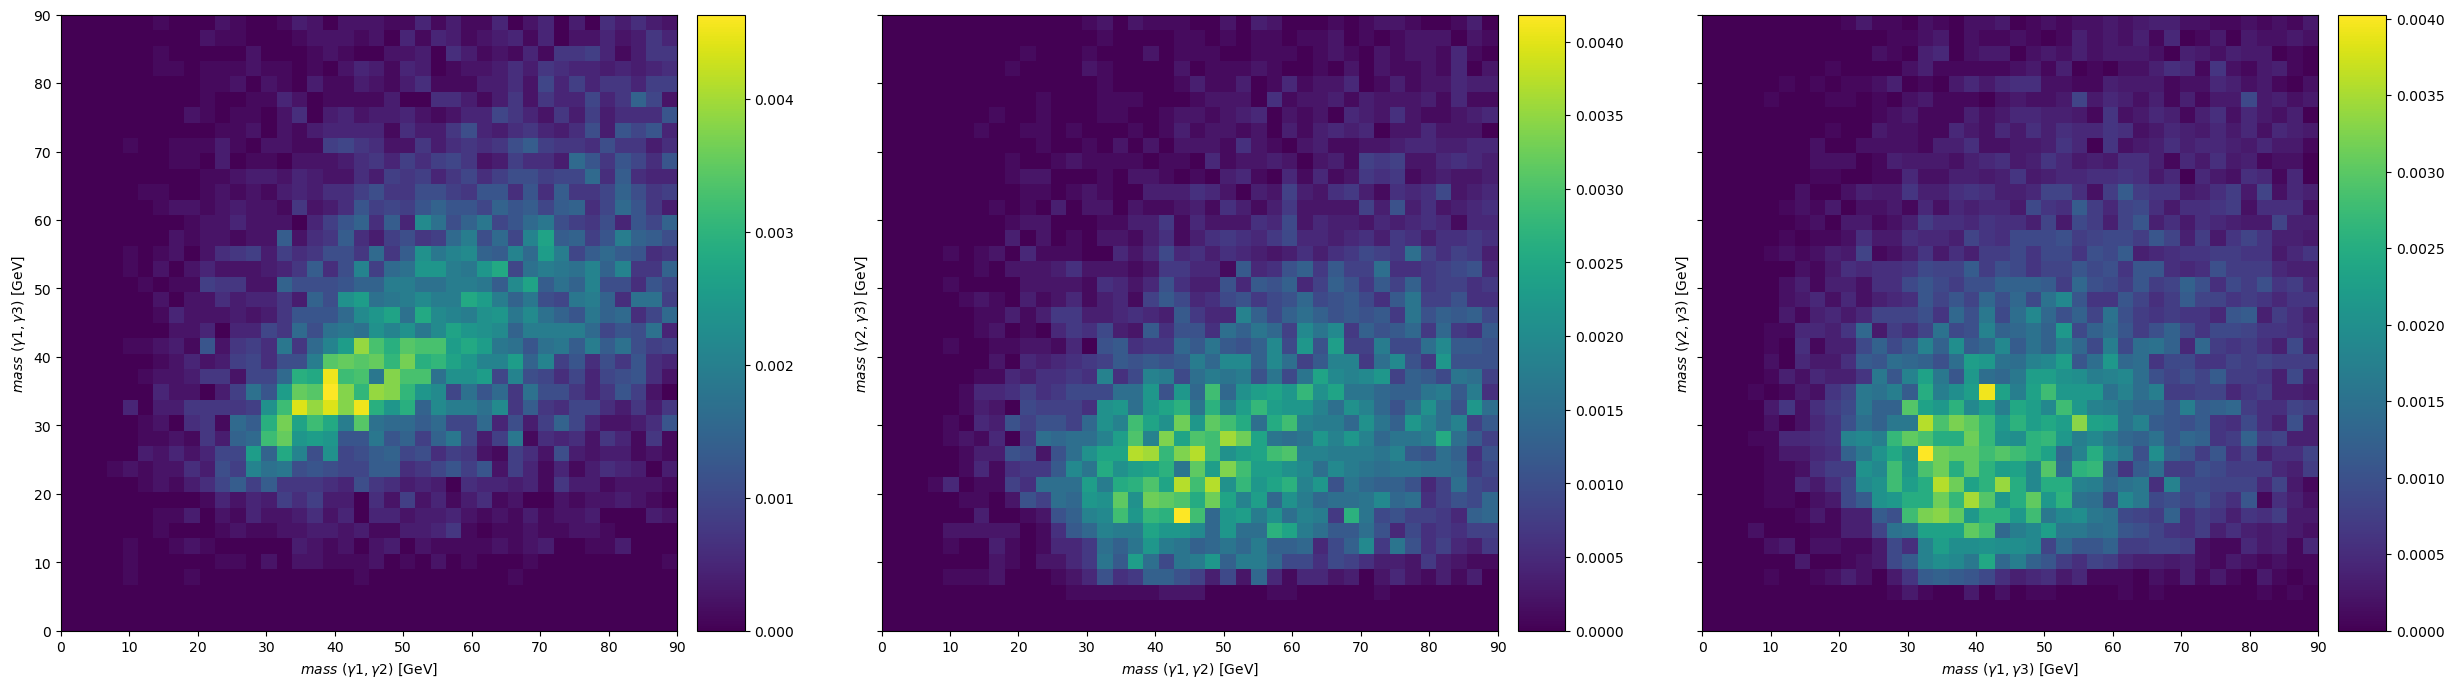

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(30,8), sharex=True, sharey=True)

(plts_normed["aaaj_sm"]["h2d_pho12_pho13_mass"]).plot(flow=False,ax=ax[0])
(plts_normed["aaaj_sm"]["h2d_pho12_pho23_mass"]).plot(flow=False,ax=ax[1])
(plts_normed["aaaj_sm"]["h2d_pho13_pho23_mass"]).plot(flow=False,ax=ax[2])

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fb32059dba0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fb3205e3a90>, text=[])

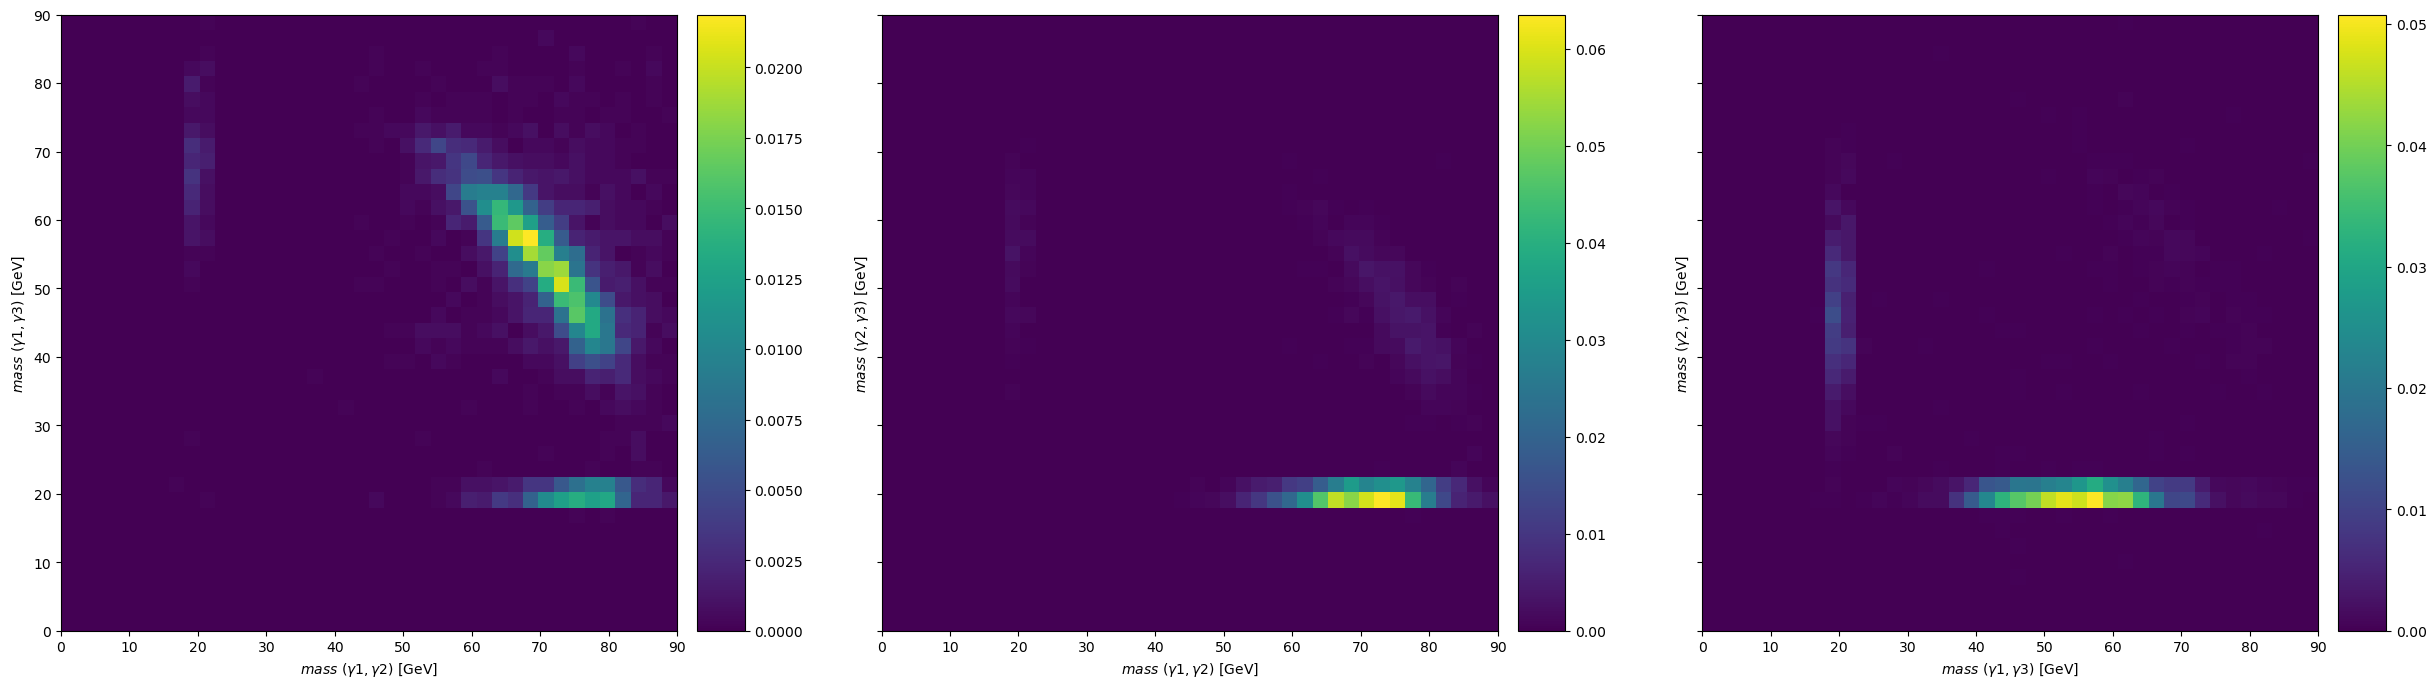

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(30,8), sharex=True, sharey=True)

(plts_normed["aaa_mphi20"]["h2d_pho12_pho13_mass"]).plot(flow=False,ax=ax[0])
(plts_normed["aaa_mphi20"]["h2d_pho12_pho23_mass"]).plot(flow=False,ax=ax[1])
(plts_normed["aaa_mphi20"]["h2d_pho13_pho23_mass"]).plot(flow=False,ax=ax[2])

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fb3221325f0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fb32219c520>, text=[])

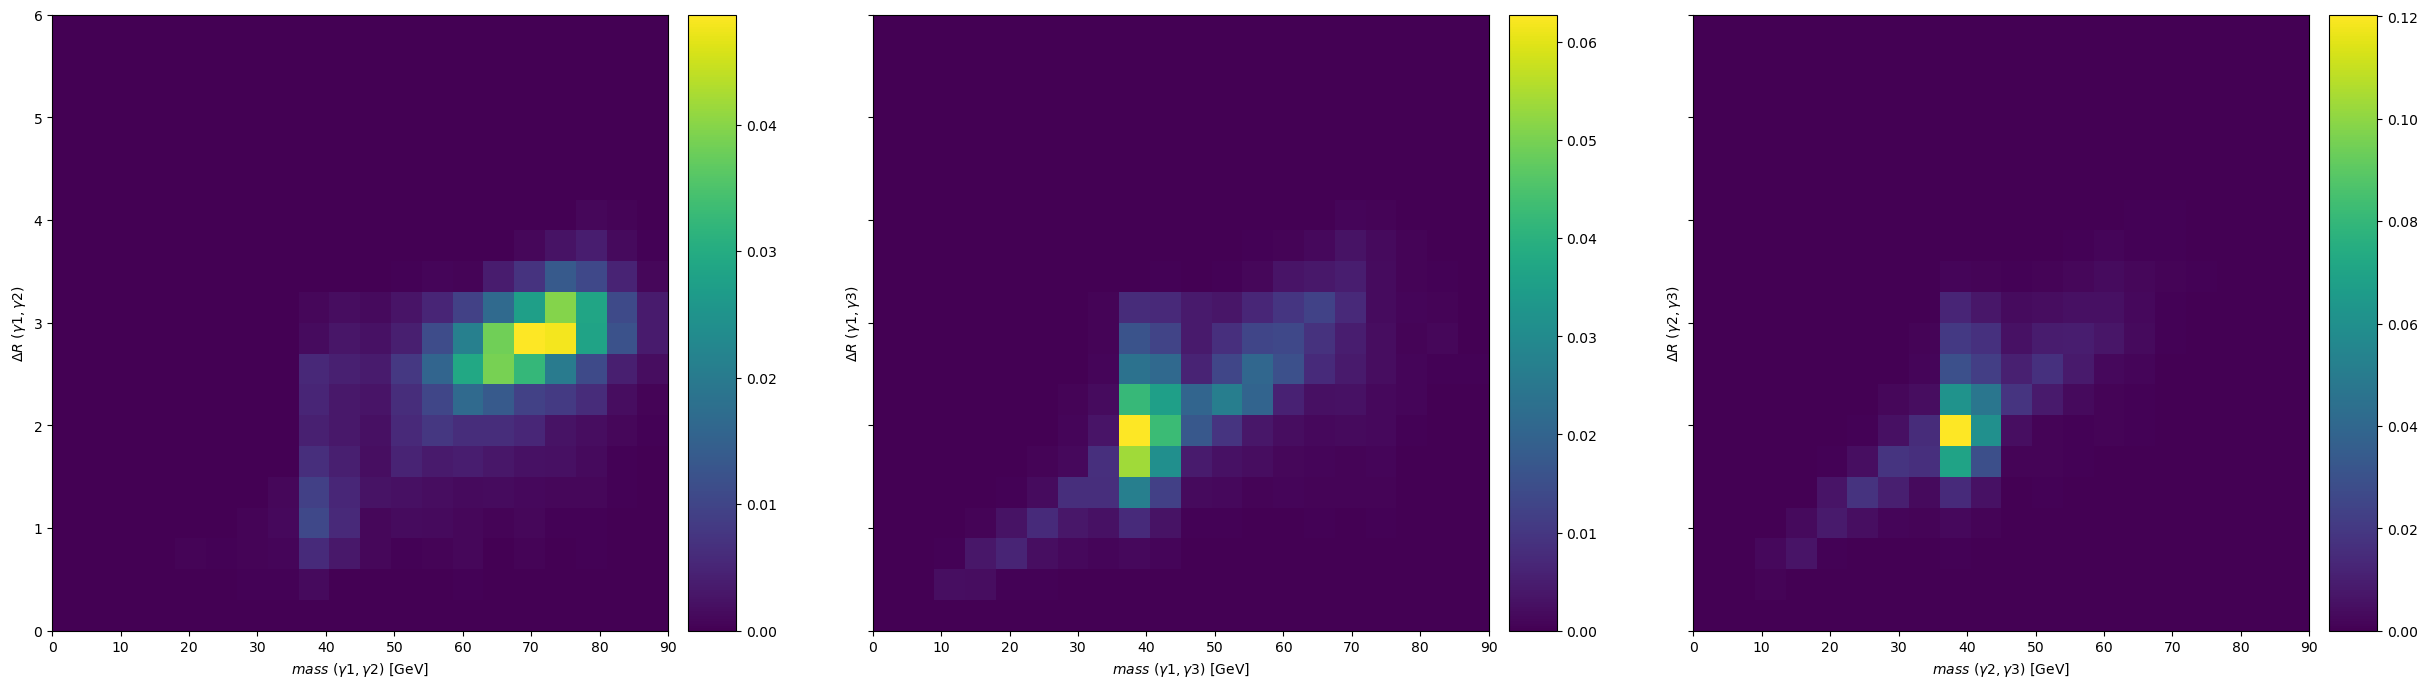

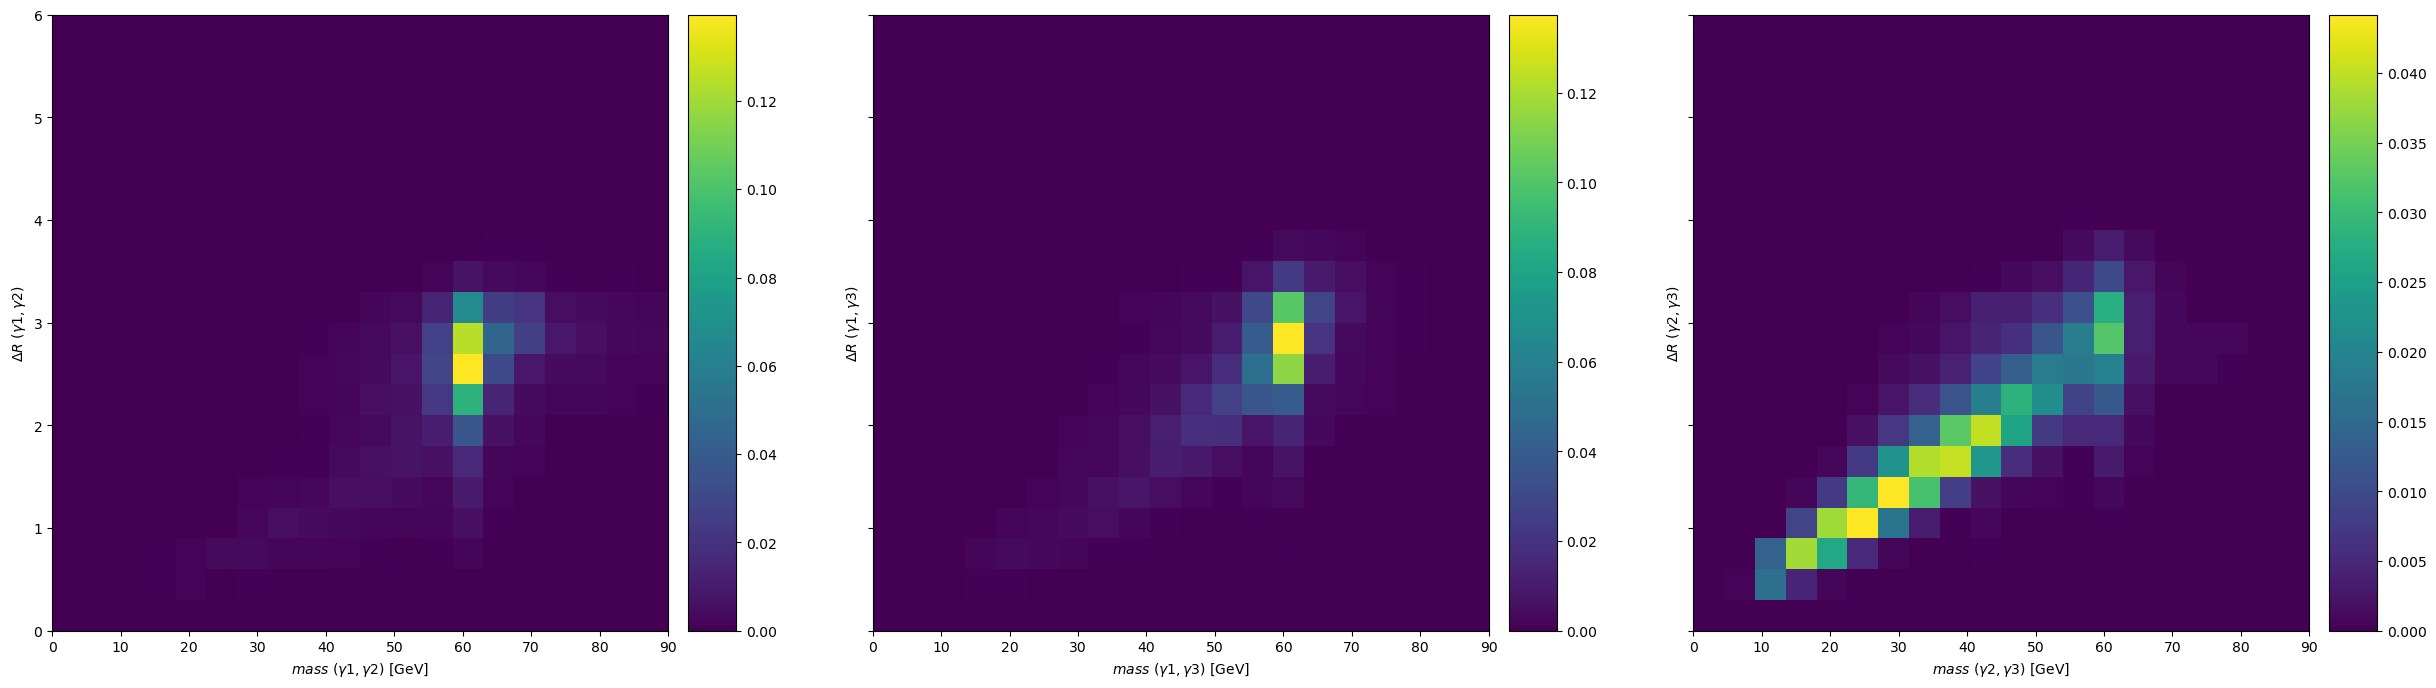

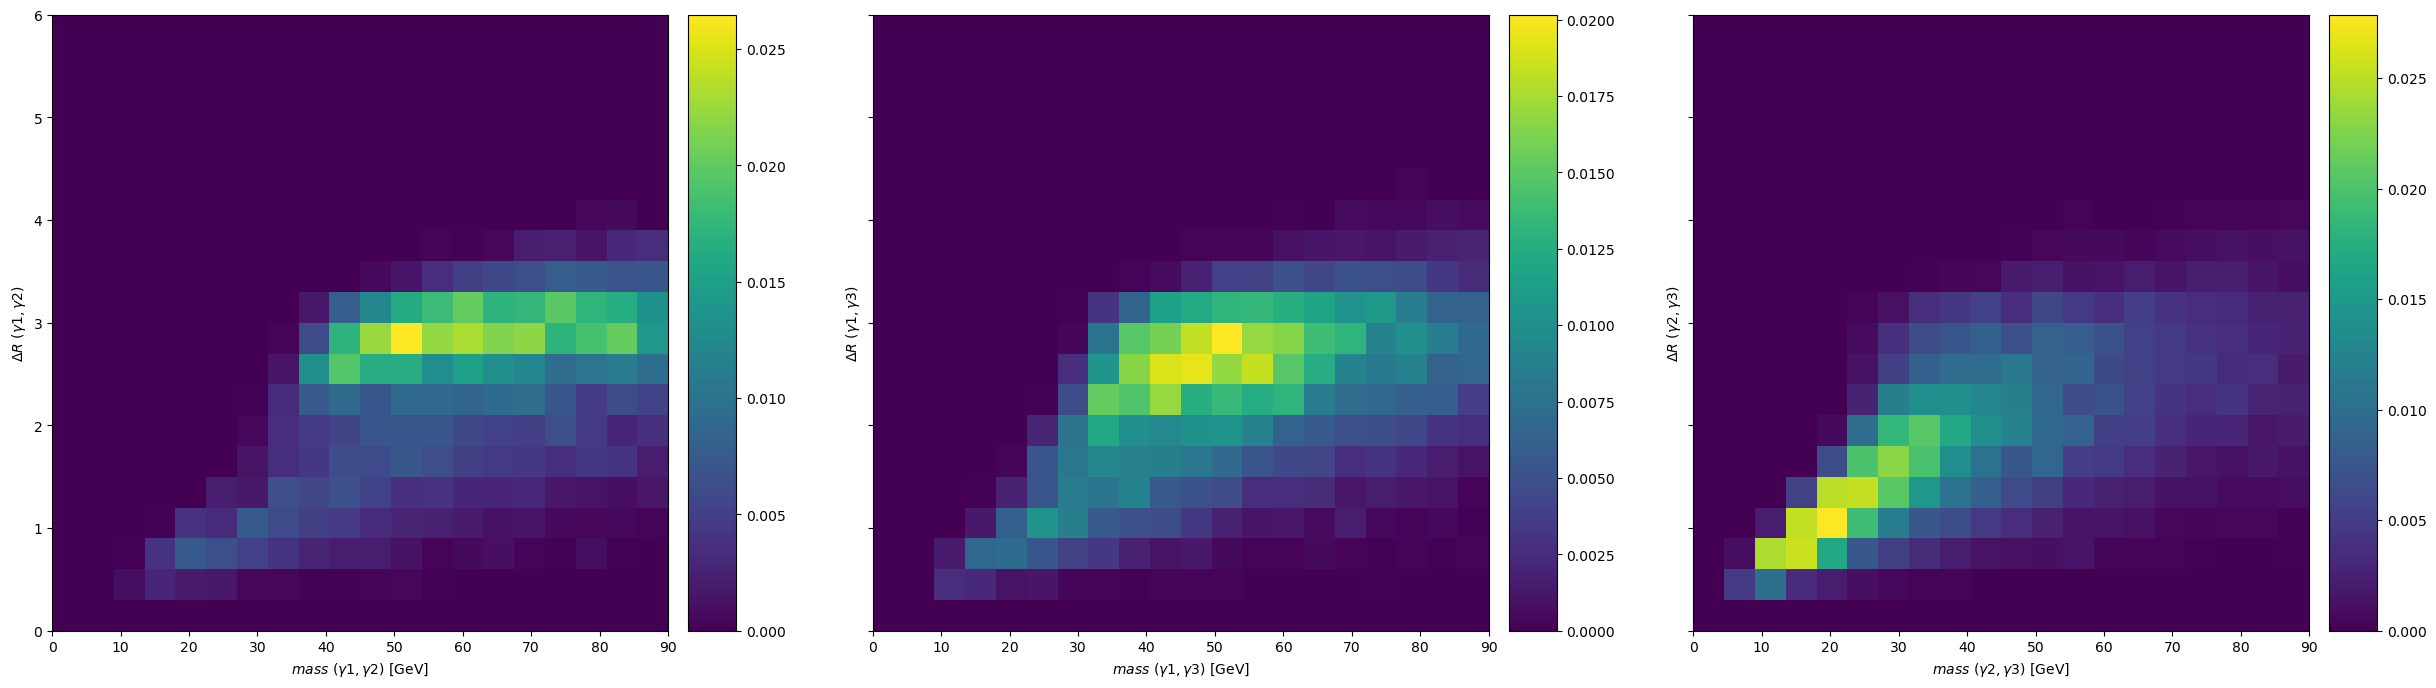

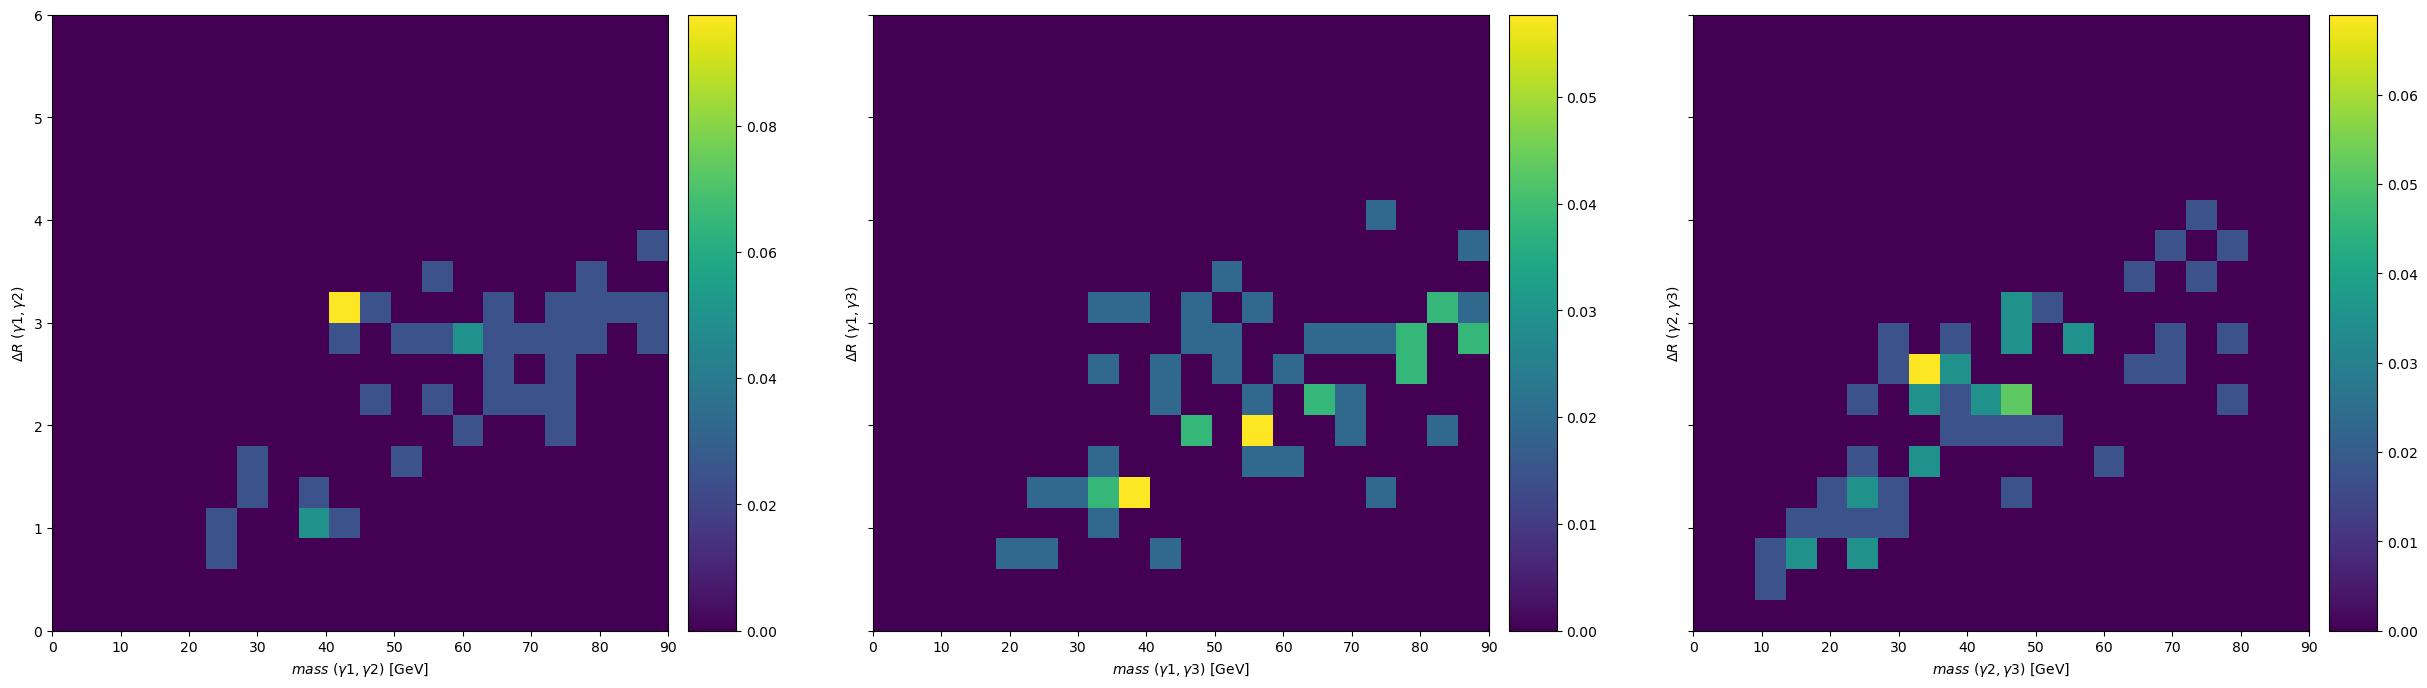

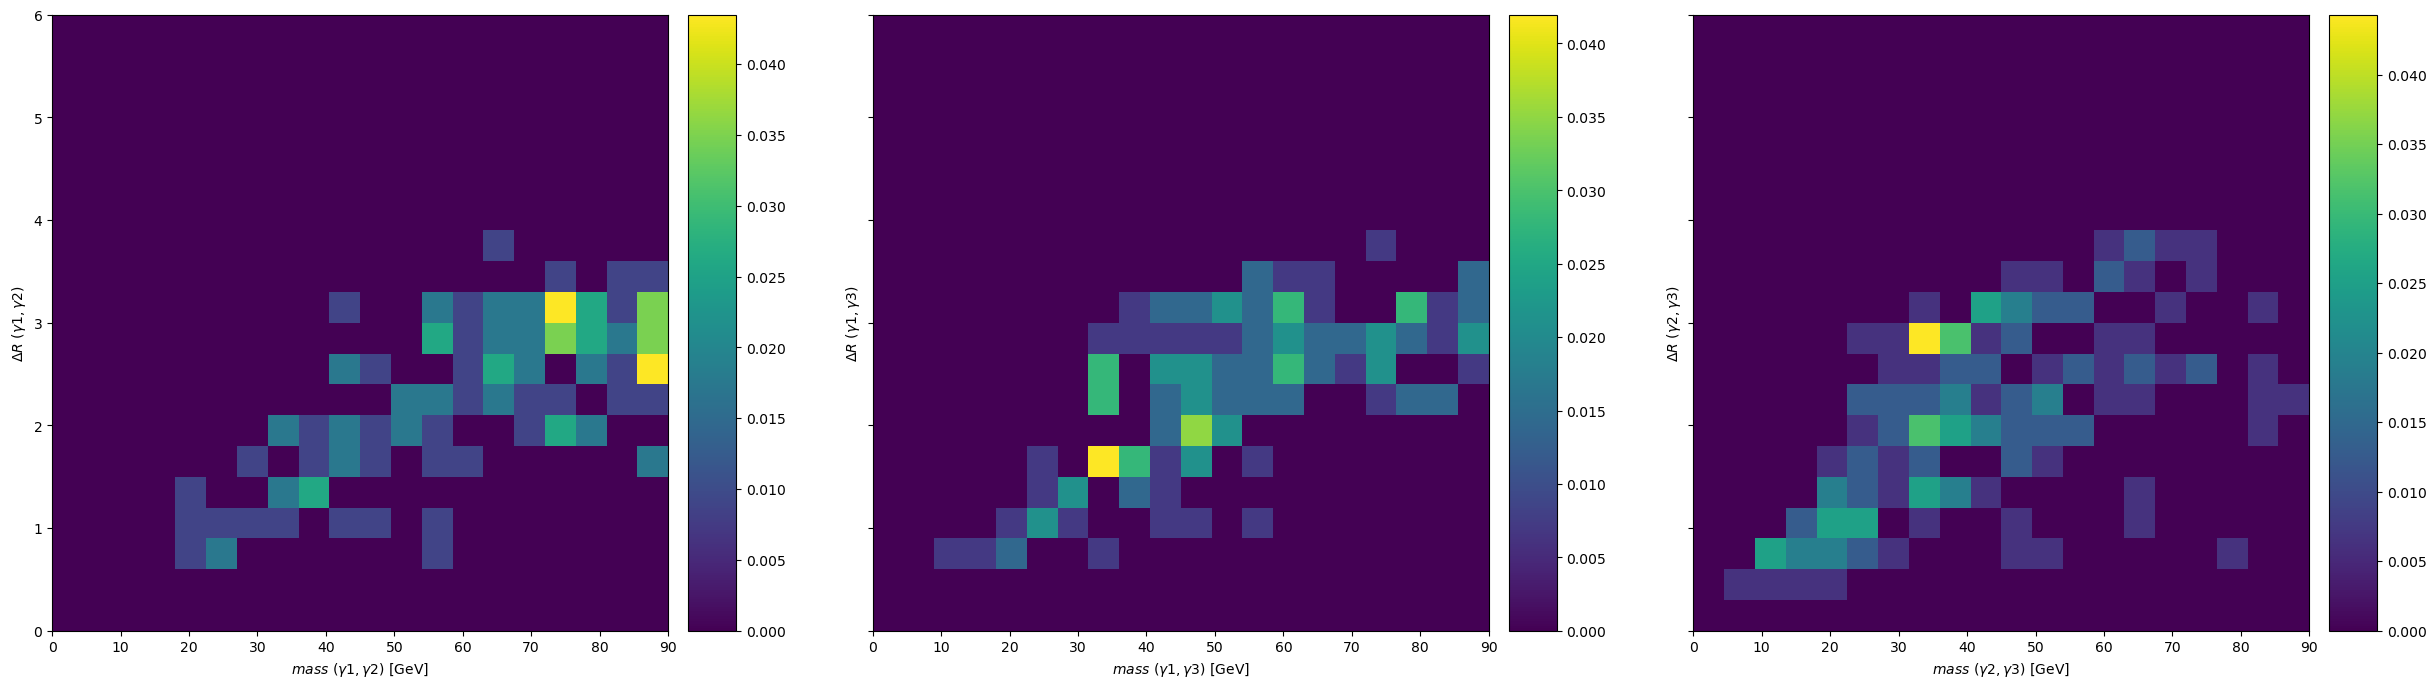

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(30,8), sharex=True, sharey=True)

(plts_normed["aaa_mphi60"]["h2d_pho12_mass_dr"]).plot(flow=False,ax=ax[0])
(plts_normed["aaa_mphi60"]["h2d_pho13_mass_dr"]).plot(flow=False,ax=ax[1])
(plts_normed["aaa_mphi60"]["h2d_pho23_mass_dr"]).plot(flow=False,ax=ax[2])

fig, ax = plt.subplots(1, 3, figsize=(30,8), sharex=True, sharey=True)

(plts_normed["aaaj_mphi60"]["h2d_pho12_mass_dr"]).plot(flow=False,ax=ax[0])
(plts_normed["aaaj_mphi60"]["h2d_pho13_mass_dr"]).plot(flow=False,ax=ax[1])
(plts_normed["aaaj_mphi60"]["h2d_pho23_mass_dr"]).plot(flow=False,ax=ax[2])

fig, ax = plt.subplots(1, 3, figsize=(30,8), sharex=True, sharey=True)

(plts_normed["aaaj_sm"]["h2d_pho12_mass_dr"]).plot(flow=False,ax=ax[0])
(plts_normed["aaaj_sm"]["h2d_pho13_mass_dr"]).plot(flow=False,ax=ax[1])
(plts_normed["aaaj_sm"]["h2d_pho23_mass_dr"]).plot(flow=False,ax=ax[2])

fig, ax = plt.subplots(1, 3, figsize=(30,8), sharex=True, sharey=True)

(plts_normed["aaj_sm"]["h2d_pho12_mass_dr"]).plot(flow=False,ax=ax[0])
(plts_normed["aaj_sm"]["h2d_pho13_mass_dr"]).plot(flow=False,ax=ax[1])
(plts_normed["aaj_sm"]["h2d_pho23_mass_dr"]).plot(flow=False,ax=ax[2])

fig, ax = plt.subplots(1, 3, figsize=(30,8), sharex=True, sharey=True)

(plts_normed["zaj_sm"]["h2d_pho12_mass_dr"]).plot(flow=False,ax=ax[0])
(plts_normed["zaj_sm"]["h2d_pho13_mass_dr"]).plot(flow=False,ax=ax[1])
(plts_normed["zaj_sm"]["h2d_pho23_mass_dr"]).plot(flow=False,ax=ax[2])

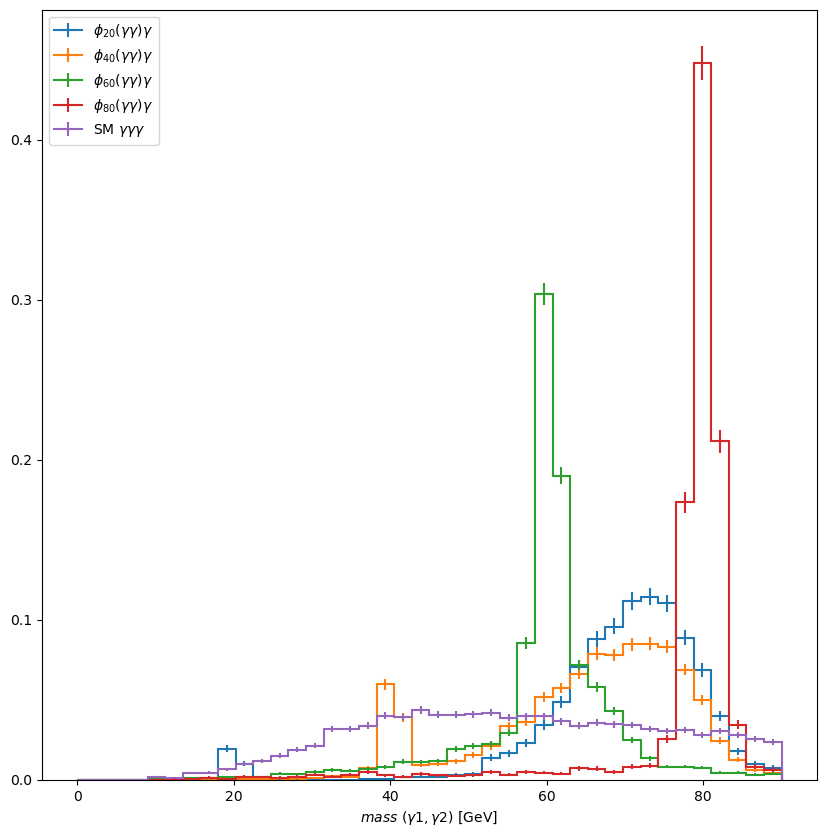

In [103]:
fig, ax = plt.subplots(figsize=(10,10))

(plts_normed["aaaj_mphi20"]["h_pho12_mass"]).plot(flow=False,ax=ax,label=r"$\phi_{20}(\gamma\gamma)\gamma$")
(plts_normed["aaaj_mphi40"]["h_pho12_mass"]).plot(flow=False,ax=ax,label=r"$\phi_{40}(\gamma\gamma)\gamma$")
(plts_normed["aaaj_mphi60"]["h_pho12_mass"]).plot(flow=False,ax=ax,label=r"$\phi_{60}(\gamma\gamma)\gamma$")
(plts_normed["aaaj_mphi80"]["h_pho12_mass"]).plot(flow=False,ax=ax,label=r"$\phi_{80}(\gamma\gamma)\gamma$")
(plts_normed["aaaj_sm"]["h_pho12_mass"]).plot(flow=False,ax=ax,label=r"SM $\gamma \gamma\gamma$")
# (plts_normed["aaj_sm"]["h_pho12_mass"]).plot(flow=False,ax=ax,label=r"SM $\gamma \gamma$")
# (plts_normed["zaj_sm"]["h_pho12_mass"]).plot(flow=False,ax=ax,label=r"SM Z$ \gamma$")

plt.legend()

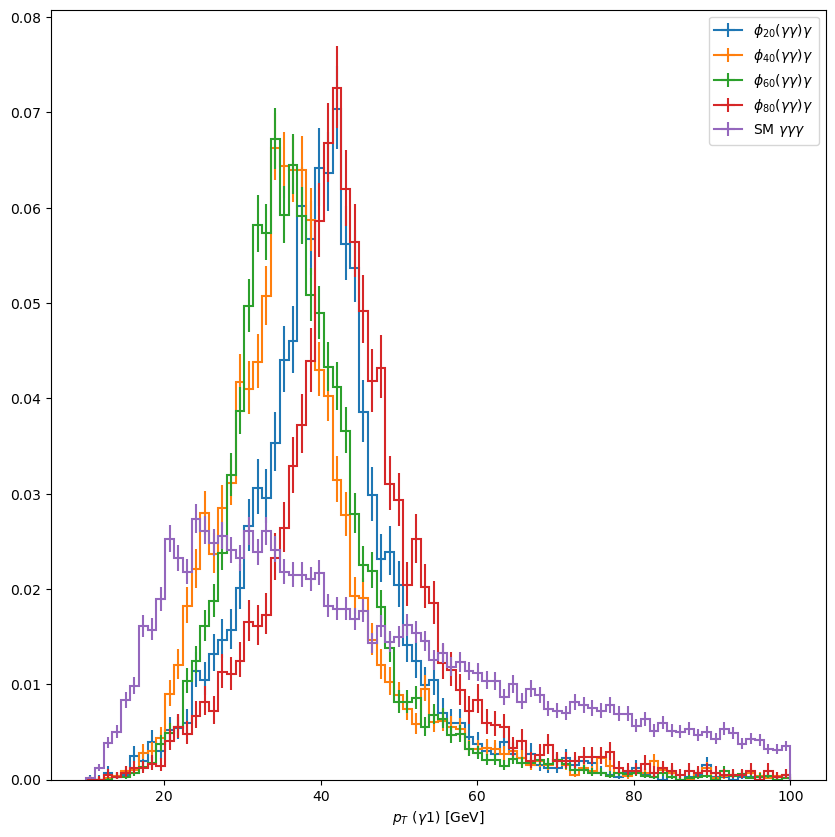

In [105]:
fig, ax = plt.subplots(figsize=(10,10))

(plts_normed["aaaj_mphi20"]["h_pho1_pt"]).plot(flow=False,ax=ax,label=r"$\phi_{20}(\gamma\gamma)\gamma$")
(plts_normed["aaaj_mphi40"]["h_pho1_pt"]).plot(flow=False,ax=ax,label=r"$\phi_{40}(\gamma\gamma)\gamma$")
(plts_normed["aaaj_mphi60"]["h_pho1_pt"]).plot(flow=False,ax=ax,label=r"$\phi_{60}(\gamma\gamma)\gamma$")
(plts_normed["aaaj_mphi80"]["h_pho1_pt"]).plot(flow=False,ax=ax,label=r"$\phi_{80}(\gamma\gamma)\gamma$")
(plts_normed["aaaj_sm"]["h_pho1_pt"]).plot(flow=False,ax=ax,label=r"SM $\gamma \gamma\gamma$")
# (plts_normed["aaj_sm"]["h_pho12_mass"]).plot(flow=False,ax=ax,label=r"SM $\gamma \gamma$")
# (plts_normed["zaj_sm"]["h_pho12_mass"]).plot(flow=False,ax=ax,label=r"SM Z$ \gamma$")

plt.legend()

In [8]:
# a=ak.Array([0,1,-1,0,3,4])
# b=ak.Array([0,0,0,1,3,4])
# c=a/b
# c
# np.clip(ak.nan_to_num(c,nan=1),-1000,+1000)